# 1) Kütüphane yüklemeleri

In [ ]:
!pip install -q xgboost lightgbm catboost imbalanced-learn scikit-plot

In [4]:
import os
import time
from collections import Counter

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier
from scipy.special import softmax
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, log_loss,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Matplotlib - Seaborn ayarları
plt.rcParams["figure.figsize"] = (12, 4)
sns.set(style="whitegrid")
pd.options.display.float_format = "{:.3f}".format

RANDOM_STATE = 42
AUTOTUNE = -1


# 💾 2) Google Drive'ı bağla & veriyi yükle


In [ ]:
drive.mount("/content/drive")  # force_remount=True gerekirse
DATA_PATH = "/content/drive/MyDrive/log2.csv"    # yolu uyarlayın

df = pd.read_csv(DATA_PATH)
print("Ham veri boyutu:", df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ham veri boyutu: (65532, 12)


# 🧹 3) Ön-işleme: kolon adları & LabelEncode


In [ ]:
df.columns = (df.columns
              .str.lower()
              .str.replace(" ", "_", regex=False))

le = LabelEncoder()
df["action"] = le.fit_transform(df["action"])
print("Etiket haritası:", dict(zip(le.classes_, le.transform(le.classes_))))


Etiket haritası: {'allow': np.int64(0), 'deny': np.int64(1), 'drop': np.int64(2), 'reset-both': np.int64(3)}


# ✂️ 4) Train/Test böl & sütun tipleri


In [ ]:
X = df.drop(columns="action")
y = df["action"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


# 🤖 5) Model sözlüğü (14 algoritma)


In [ ]:
NUM_CLASSES = len(le.classes_)

models = {
    "LogReg":      LogisticRegression(max_iter=500, n_jobs=AUTOTUNE),
    "GaussianNB":  GaussianNB(),
    "kNN":         KNeighborsClassifier(n_jobs=AUTOTUNE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, n_jobs=AUTOTUNE, random_state=RANDOM_STATE),
    "ExtraTrees":  ExtraTreesClassifier(
        n_estimators=300, n_jobs=AUTOTUNE, random_state=RANDOM_STATE),
    "AdaBoost":    AdaBoostClassifier(random_state=RANDOM_STATE),
    "GradBoost":   GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVM (RBF)":   SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "LinearSVC":   LinearSVC(max_iter=10000, random_state=RANDOM_STATE),
    "XGBoost":     XGBClassifier(
        objective="multi:softprob",
        num_class=NUM_CLASSES,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=AUTOTUNE,
        random_state=RANDOM_STATE),
    "LightGBM":    LGBMClassifier(
        objective="multiclass",
        num_class=NUM_CLASSES,
        n_jobs=AUTOTUNE,
        random_state=RANDOM_STATE),
    "LDA":         LDA(),
    "QDA":         QDA()
}


# 🏃‍♂️ 6) Eğitim + değerlendirme  

In [ ]:
def proba_or_softmax(model, X):
    """predict_proba varsa kullan; decision_function varsa softmax uygula."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    if hasattr(model, "decision_function"):
        return softmax(model.decision_function(X), axis=1)
    return None  # log_loss hesaplanamaz

results = []
start = time.time()

for name, clf in models.items():
    print(f"⏳ {name} eğitiliyor...")
    pipe = ImbPipeline([
        ("prep", preprocess),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)

    y_pred  = pipe.predict(X_test)
    proba   = proba_or_softmax(pipe, X_test)

    results.append({
        "model":      name,
        "accuracy":   accuracy_score(y_test, y_pred),
        "f1_macro":   f1_score(y_test, y_pred, average="macro"),
        "precision":  precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall":     recall_score(y_test, y_pred, average="macro", zero_division=0),
        "log_loss":   log_loss(y_test, proba) if proba is not None else np.nan
    })

print("Toplam süre:", round(time.time() - start, 1), "sn")

results_df = (pd.DataFrame(results)
              .set_index("model")
              .sort_values("f1_macro", ascending=False))
results_df


⏳ LogReg eğitiliyor...
⏳ GaussianNB eğitiliyor...
⏳ kNN eğitiliyor...
⏳ DecisionTree eğitiliyor...
⏳ RandomForest eğitiliyor...
⏳ ExtraTrees eğitiliyor...
⏳ AdaBoost eğitiliyor...
⏳ GradBoost eğitiliyor...
⏳ SVM (RBF) eğitiliyor...
⏳ LinearSVC eğitiliyor...
⏳ XGBoost eğitiliyor...
⏳ LightGBM eğitiliyor...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 120448, number of used features: 11
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


⏳ LDA eğitiliyor...
⏳ QDA eğitiliyor...
Toplam süre: 1143.1 sn


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


,accuracy,f1_macro,precision,recall,log_loss
model,,,,,
RandomForest,0.997,0.848,0.859,0.839,0.030
LightGBM,0.997,0.842,0.816,0.907,0.013
ExtraTrees,0.997,0.837,0.821,0.861,0.032
XGBoost,0.997,0.833,0.807,0.906,0.013
DecisionTree,0.997,0.827,0.819,0.838,0.105
GradBoost,0.994,0.795,0.777,0.925,0.023
kNN,0.989,0.767,0.760,0.876,0.162
GaussianNB,0.991,0.760,0.755,0.814,0.301
SVM (RBF),0.931,0.707,0.739,0.816,0.156


# 📊 7) Başlıca metrik grafikleri


<ipython-input-10-13270ac55398>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette="mako")


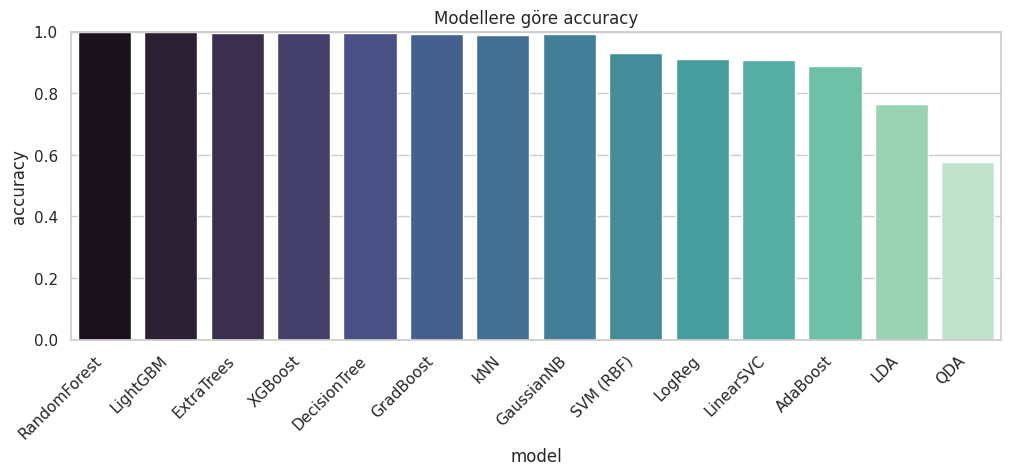

<ipython-input-10-13270ac55398>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette="mako")


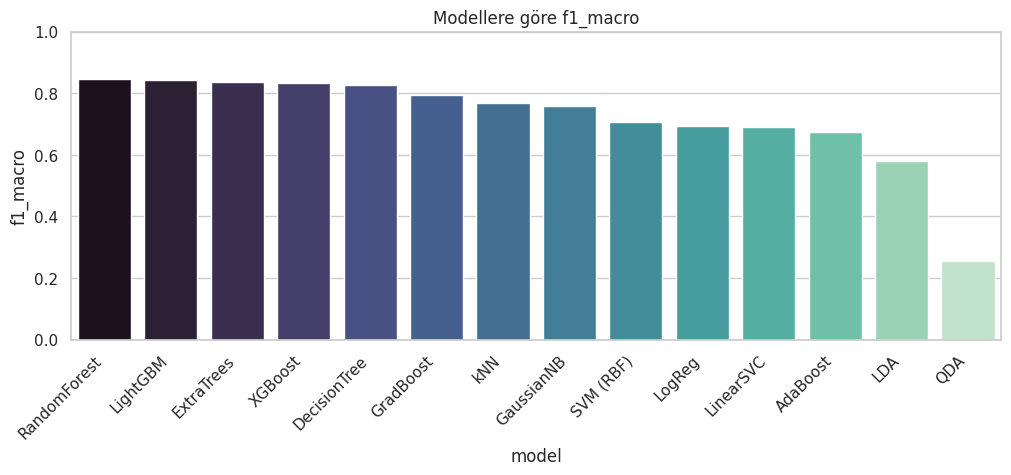

<ipython-input-10-13270ac55398>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette="mako")


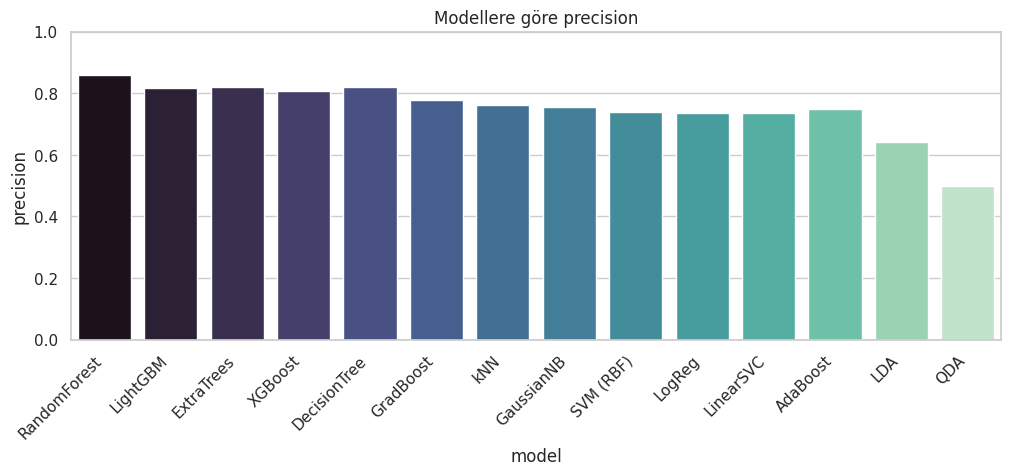

<ipython-input-10-13270ac55398>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette="mako")


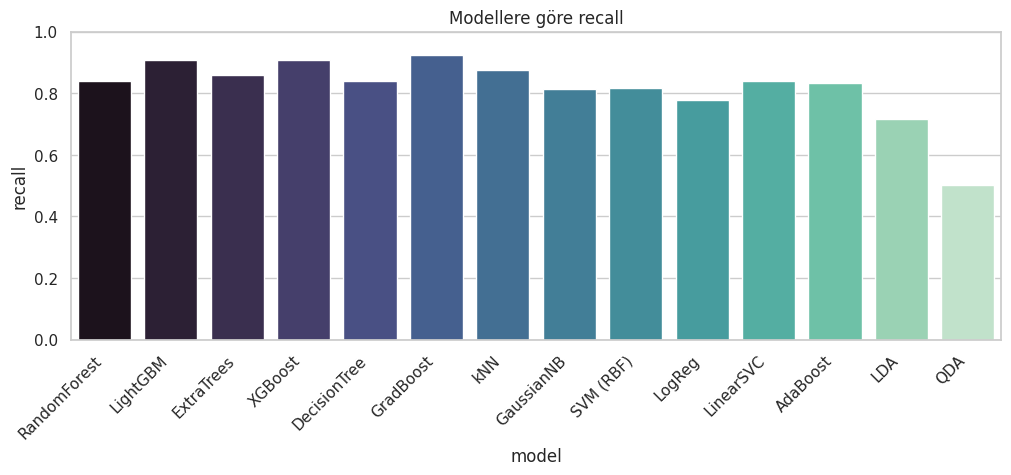

<ipython-input-10-13270ac55398>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette="mako")


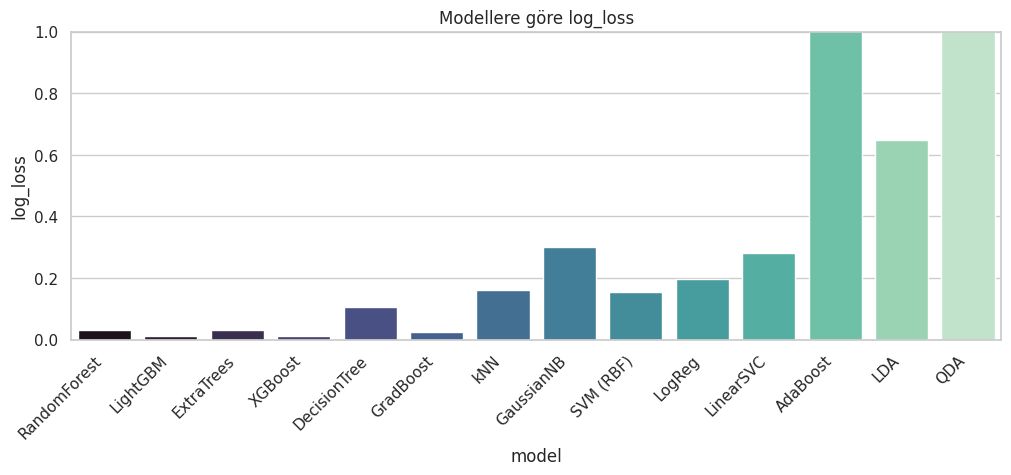

In [ ]:
for metric in ["accuracy", "f1_macro","precision","recall","log_loss"]:
    plt.figure()
    sns.barplot(x=results_df.index, y=metric, data=results_df, palette="mako")
    plt.title(f"Modellere göre {metric}")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right")
    plt.show()


# 💾 8) En iyi modeli (F1-macro) kaydet


In [ ]:
best_name  = results_df.index[0]
print("En iyi model:", best_name)

final_pipe = ImbPipeline([
    ("prep", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf",   models[best_name])
]).fit(X, y)

MODEL_PATH = "/content/drive/MyDrive/best_firewall_clf.pkl"
joblib.dump(final_pipe, MODEL_PATH)
print(f"✔️  Model kaydedildi → {MODEL_PATH}")


En iyi model: RandomForest
✔️  Model kaydedildi → /content/drive/MyDrive/best_firewall_clf.pkl


In [ ]:
# Kaydedilecek modellerin isimleri
chosen = ["RandomForest", "LightGBM"]

for name in chosen:
    print(f"🔄  {name} tüm veri üzerinde yeniden eğitiliyor…")
    pipe = ImbPipeline([
        ("prep", preprocess),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf",   models[name])
    ]).fit(X, y)

    model_path = f"/content/drive/MyDrive/{name.lower()}_firewall_clf.pkl"
    joblib.dump(pipe, model_path)
    print(f"✔️  {name} kaydedildi → {model_path}\n")


🔄  RandomForest tüm veri üzerinde yeniden eğitiliyor…
✔️  RandomForest kaydedildi → /content/drive/MyDrive/randomforest_firewall_clf.pkl

🔄  LightGBM tüm veri üzerinde yeniden eğitiliyor…


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 150560, number of used features: 11
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✔️  LightGBM kaydedildi → /content/drive/MyDrive/lightgbm_firewall_clf.pkl



#DENEME

In [2]:
# ================= 0) Ortam kurulumu =================
    # Tek seferlik

import joblib, pandas as pd, numpy as np

MODEL_PATH = "/content/drive/MyDrive/best_firewall_clf.pkl"  # gerekiyorsa değiştir
pipe = joblib.load(MODEL_PATH)

# LabelEncoder eğitimde alfabetik sıraladığı için:
LABELS = {0: "allow", 1: "deny", 2: "drop", 3: "reset-both"}

COLS = [
    "source_port", "destination_port", "nat_source_port", "nat_destination_port",
    "bytes", "bytes_sent", "bytes_received", "packets", "elapsed_time_(sec)",
    "pkts_sent", "pkts_received"
]

# ================= 1) Tekil akışı tahmin et =================
def predict_flow(source_port, destination_port,
                 nat_source_port=0, nat_destination_port=0,
                 bytes_=0, bytes_sent=0, bytes_received=0,
                 packets=1, elapsed_time_sec=0,
                 pkts_sent=1, pkts_received=0):
    """
    İçerik alanlarını ver → tahmin ve olasılıkları yazdır.
    Eğitiminle aynı COLS sırasını kullanır.
    """
    row = pd.DataFrame([{
        "source_port":        source_port,
        "destination_port":   destination_port,
        "nat_source_port":    nat_source_port,
        "nat_destination_port": nat_destination_port,
        "bytes":              bytes_,
        "bytes_sent":         bytes_sent,
        "bytes_received":     bytes_received,
        "packets":            packets,
        "elapsed_time_(sec)": elapsed_time_sec,
        "pkts_sent":          pkts_sent,
        "pkts_received":      pkts_received
    }], columns=COLS)

    pred_num = pipe.predict(row)[0]
    probs    = pipe.predict_proba(row)[0]

    print(f"👉 Tahmin: {LABELS[pred_num]}  (etiket={pred_num})")
    for i, p in enumerate(probs):
        print(f"   P({LABELS[i]}): {p:.3f}")

    return pred_num, probs

# ================= 2) Örnek denemeler =================
# a) Tek SSH ACK paketi (yüksek ihtimalle 'deny')
predict_flow(
    source_port=12864, destination_port=22,
    bytes_=40, bytes_sent=40,
    packets=1, pkts_sent=1
)

# b) Tipik HTTP GET oturumu (örnek değerler) – muhtemelen 'allow'
predict_flow(
    source_port=53214, destination_port=80,
    bytes_=1500, bytes_sent=800, bytes_received=700,
    packets=10, elapsed_time_sec=1,
    pkts_sent=6, pkts_received=4
)


👉 Tahmin: deny  (etiket=1)
   P(allow): 0.000
   P(deny): 1.000
   P(drop): 0.000
   P(reset-both): 0.000
👉 Tahmin: allow  (etiket=0)
   P(allow): 0.863
   P(deny): 0.130
   P(drop): 0.000
   P(reset-both): 0.007


(np.int64(0), array([0.86333333, 0.13      , 0.        , 0.00666667]))